In [ ]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from yellowbrick.regressor import prediction_error
print("Make sure to install shap as: !pip install shap")
!pip install shap
import shap

Make sure to install shap as: !pip install shap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.2 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
#check for shap installed
stream = os.popen('pip list')

pip_list = stream.read()

Package=list(pip_list.split(" "))
# Count variable
c = 0
for i in Package:
    if "shap" in i:
        c = 1

# Checking the value of c
if c==1:
  print("Shap Installed")
else :
  print("Shap is not installed")

Shap Installed


In [ ]:

# Constructing paths based on zone and resolution
home = input("Enter the home directory where the datasets are located (example:/content/ARM_ERA_12)")

# Asking the user for the resolution of the dataset
resolution = [input("Enter the name/resolution of the dataset(example: 1000m ): ")]

#1000m_dataV1_train.csv
# Asking for the name of the training dataset and constructing the full path
train_dataset_name = input("Enter the name of the training dataset (including file extension - example: 1000m_dataV1_train.csv): ")
train_file = home + '/' + train_dataset_name

# Checking if the training file exists and prompting the user until a valid file is provided
while not os.path.exists(train_file):
    print("The specified training file does not exist. Please enter the correct dataset  with the correct format.")
    train_dataset_name = input("Enter the name of the training dataset (including file extension): ")
    train_file = home + '/' + train_dataset_name



Enter the home directory where the datasets are located (example:/content/ARM_ERA_12)/content/Airmoss
Enter the name/resolution of the dataset(example: 1000m ): 1400m
Enter the name of the training dataset (including file extension - example: 1000m_dataV1_train.csv): A4_1400m_processed_train.csv
The specified training file does not exist. Please enter the correct dataset  with the correct format.
Enter the name of the training dataset (including file extension): A4_1400m_processed__train.csv


In [ ]:
#_dataV1_test.csv
# Asking for the name of the testing dataset and constructing the full path
test_dataset_name = input("Enter the name of the testing dataset (including file extension - example: 1000m_dataV1_test.csv): ")
test_file = home + '/' + test_dataset_name

# Checking if the testing file exists and prompting the user until a valid file is provided
while not os.path.exists(test_file):
    print("The specified testing file does not exist. Please enter the correct dataset name with the correct format.")
    test_dataset_name = input("Enter the name of the testing dataset (including file extension - example: 1000m_dataV1_test.csv): ")
    test_file = home + '/' + test_dataset_name

Enter the name of the testing dataset (including file extension - example: 1000m_dataV1_test.csv): A4_1400m_processed_test.csv
The specified testing file does not exist. Please enter the correct dataset name with the correct format.
Enter the name of the testing dataset (including file extension - example: 1000m_dataV1_test.csv): A4_1400m_processed__test.csv


In [ ]:
# Reading training data
train_data = pd.read_csv(train_file,
                         usecols=['SMERGE', 'Date', 'Temp', 'PageName', 'LAI', 'Albedo', 'NDVI', 'Clay', 'Sand', 'Silt',
                                  'Slope', 'Elevation', 'Ascept'])

train_page = train_data['PageName']
train_date = train_data['Date']


In [ ]:
# Reading test data
test_data = pd.read_csv(test_file,
                        usecols=['SMERGE', 'Date', 'Temp', 'PageName', 'LAI', 'Albedo', 'NDVI', 'Clay', 'Sand', 'Silt',
                                 'Slope', 'Elevation', 'Ascept'])
test_page = test_data[['PageName']]
test_ndvi = test_data['NDVI']
test_dates = test_data['Date']


In [ ]:
# Processing 'Date' column for training and testing
train_data['Date'] = pd.to_datetime(train_data['Date'], format="%m/%d/%Y").astype(int)
test_data['Date'] = pd.to_datetime(test_data['Date'], format="%m/%d/%Y").astype(int)

ValueError: ignored

In [ ]:
#Separating target data and variables
y_train = train_data['SMERGE']
x_train = train_data[
    ['Clay', 'Sand', 'Silt', 'Elevation', 'Ascept', 'Slope', 'NDVI', 'Date', 'LAI', 'Albedo', 'Temp']]
print(train_data)

      PageName       Clay       Sand       Silt   Elevation     Slope  \
0          L53  22.100727  40.364609  37.534664  318.411656  3.193839   
1          I56  25.391205  44.240216  30.368579  325.505550  2.418342   
2          N52  25.654487  43.462206  30.883307  327.161159  2.031697   
3          T55  25.413677  47.903231  26.683093  308.577637  2.637925   
4          E90  22.868792  31.931610  45.199599  290.743429  2.376298   
...        ...        ...        ...        ...         ...       ...   
18423      C73  25.251914  46.805069  27.943017  307.013581  2.783847   
18424      T30  10.854833  12.053032  77.092136  351.373925  0.927055   
18425      M30  35.937595  42.408647  21.653758  319.124422  2.026835   
18426      O50  23.717001  40.304656  35.978343  303.411193  3.139278   
18427      S20  10.858210  11.378185  77.763605  338.925331  0.392443   

           Ascept        NDVI      SMERGE      Date        LAI      Albedo  \
0      159.854210  153.031452  197.000000  20

In [ ]:
#Separating target data and variables
y_test = test_data['SMERGE']
x_test = test_data[
    ['Clay', 'Sand', 'Silt', 'Elevation', 'Ascept', 'Slope', 'NDVI', 'Date', 'LAI', 'Albedo', 'Temp']]
print(test_data)

     PageName       Clay       Sand       Silt   Elevation     Slope  \
0         O50  23.717001  40.304656  35.978343  303.411193  3.139278   
1         R14   6.154640   6.583198  87.262161  334.368178  1.126997   
2         J69  26.803839  36.507013  36.689148  296.900555  2.471590   
3         P28  24.703475  43.008623  32.287902  352.733117  0.704322   
4         R37  31.558232  47.896606  20.545162  315.992304  1.355527   
...       ...        ...        ...        ...         ...       ...   
7893      R25  13.488648  15.966095  70.545257  359.376188  0.479915   
7894      O12  14.835172  18.181080  66.983749  350.952015  0.780532   
7895      L18  23.484458  50.506734  26.008809  346.257583  1.304944   
7896      N56  21.438964  44.214903  34.346133  296.469473  2.092929   
7897      Q58  25.533004  44.190448  30.276548  287.833409  2.714330   

          Ascept        NDVI      SMERGE      Date        LAI      Albedo  \
0     157.924336  148.647086  204.826087  20141021   8.285

Accuracy: 0.956993443314072

RMSE:  9.99

R-Squared:  0.96

Prediction Error Plot


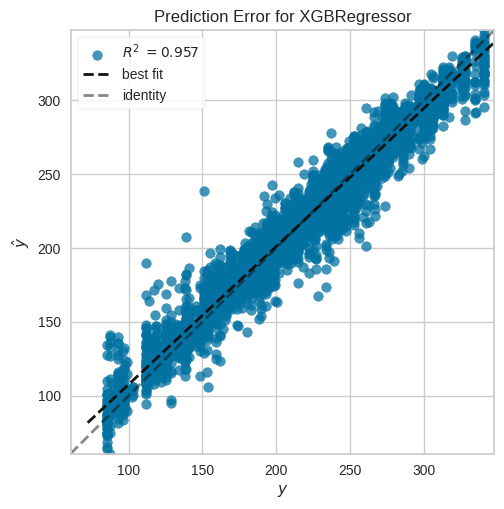

PredictionError(ax=<Axes: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, gpu_id=None,
                                       grow_policy=None, importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_one

100%|===================| 995/1000 [01:06<00:00]       

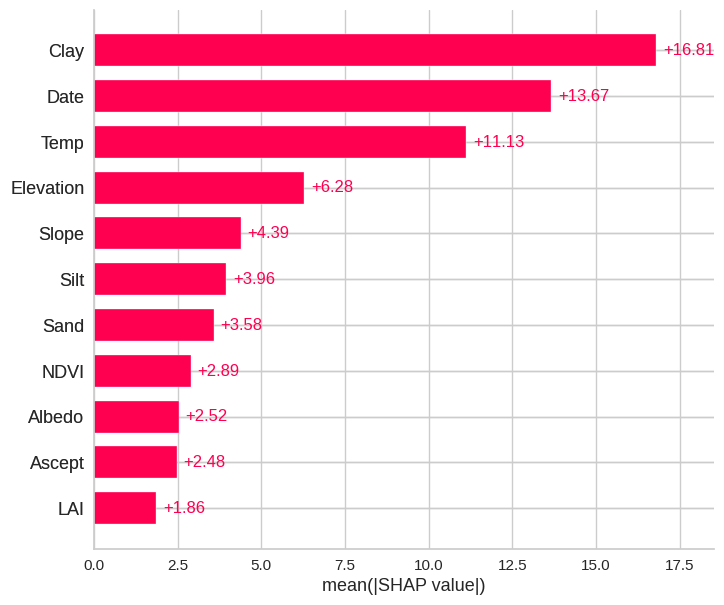

Would you like to save the variable importance plot?: y/ny


In [ ]:
# Configuring the XGBoost model
model = XGBRegressor(verbosity=1,n_estimators=500,max_depth=10,tree_method='gpu_hist')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Compiling and training the model
model.fit(x_train, y_train)

# Predicting and evaluating the model with the trained model
h = model.predict(x_test)
accuracy = model.score(x_test, y_test)
print('Accuracy:', accuracy)
MSE = mse(y_test, h)
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, h)
print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))

# Preparing the output dataframe
test_data['Date'] = test_dates
test_data['ML_'] = h
test_data['PageName'] = test_page
test_data = test_data[["Clay","Sand","Elevation","Ascept","NDVI","Date","LAI","Albedo","PageName","SMERGE","ML_"]]

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
error_plot = prediction_error(model, x_train, y_train, x_test, y_test)
print(error_plot)

# Saving the output dataframe to a CSV file
test_data.to_csv( home + resolution[0] + ".csv")

# Generating variable importance plots
x_sampled = x_train.sample(1000, random_state=10)
explainer = shap.Explainer(model, x_sampled)
shap_values = explainer(x_sampled)
shap.plots.bar(shap_values, max_display = 11)
save_shap = input("Would you like to save the variable importance plot?: y/n")
if save_shap == 'y':
#Saving varibale importance plot
  mean_shap = np.abs(shap_values.values).mean(axis=0)
  shap_pd = pd.DataFrame(mean_shap, index = x_sampled.columns).sort_values(by=[0],ascending = False)
  shap_pd.to_csv(home + resolution[0] + '_SHAP.csv')